# Import libraries

In [28]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_selector as selector
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_score, recall_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import set_config
set_config(display='diagram')

# Import precleaned data

In [2]:
df = pd.read_csv("data_cleaned.csv")
df.drop("Unnamed: 0", axis=1, inplace=True)
df.head()

,employer,record_date,comment,overall_result,interesting_tasks,equality,communication,working_conditions,supervisor_behavior,dealing_w_older_colleagues,colleague_cohesion,environmental_social awareness,salary_benefits,career_training,work_life_balance,image,overall_number
0,pumagroup,Februar 2020,"Spannendes Unternehmen, leider mit sehr intran...",recommended,4.0,4.0,4.0,3.0,3.0,4.0,1.0,1.0,2.0,2.0,5.0,3.0,1
1,sap,April 2022,Abwechslungsreiche und spannenden Aufgaben,recommended,5.0,5.0,5.0,5.0,4.0,5.0,5.0,5.0,4.0,5.0,3.0,5.0,1
2,infineon-technologies,Mai 2022,Erlebnis- und Informationsreiche Ausbildung,recommended,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
3,zalando,August 2021,Max. 1 Jahr länger möchte man dort nicht Arbeiten,not_recommended,1.0,1.0,2.0,1.0,1.0,1.0,2.0,3.0,1.0,1.0,1.0,2.0,0
4,basf-se,Januar 2022,Wenig Geld für viel Stress,recommended,5.0,4.0,5.0,4.0,5.0,5.0,5.0,3.0,3.0,5.0,3.0,5.0,1


# Model building
The goal is to build a classification model, that is able to predict weather an employee would recomment a employer based on the different rating features

## Feature selection

In [3]:
# Split data to data/feature and target 

drop_features = ["employer", "record_date", "comment", "overall_result", "overall_number"]

target = df.overall_number
data = df.drop(drop_features, axis=1)

In [4]:
# Check data types

target.info, data.dtypes

(<bound method Series.info of 0       1
 1       1
 2       1
 3       0
 4       1
        ..
 3169    0
 3170    1
 3171    1
 3172    0
 3173    0
 Name: overall_number, Length: 3174, dtype: int64>,
 interesting_tasks                 float64
 equality                          float64
 communication                     float64
 working_conditions                float64
 supervisor_behavior               float64
 dealing_w_older_colleagues        float64
 colleague_cohesion                float64
 environmental_social awareness    float64
 salary_benefits                   float64
 career_training                   float64
 work_life_balance                 float64
 image                             float64
 dtype: object)

In [5]:
print(f"Number of target samples (rows): {target.shape[0]} \n")
print(f"Number of feature samples (rows): {target.shape[0]} \n")
print(f"Number of features (columns): {data.shape[1]} \n")
print(f"Features:\n {list(data.columns)} \n")

Number of target samples (rows): 3174 

Number of feature samples (rows): 3174 

Number of features (columns): 12 

Features:
 ['interesting_tasks', 'equality', 'communication', 'working_conditions', 'supervisor_behavior', 'dealing_w_older_colleagues', 'colleague_cohesion', 'environmental_social awareness', 'salary_benefits', 'career_training', 'work_life_balance', 'image'] 



In [6]:
# There are still quite a few missing values, 
# which need to be handled (I'll try if these values can be imputed within the model pipeline)

data.isna().sum()

interesting_tasks                 166
equality                          201
communication                     147
working_conditions                169
supervisor_behavior               145
dealing_w_older_colleagues        265
colleague_cohesion                143
environmental_social awareness    250
salary_benefits                   189
career_training                   207
work_life_balance                 203
image                             228
dtype: int64

## Create train-/test split

In [7]:
data_train, data_test, target_train, target_test = train_test_split(data, target, test_size=0.25, random_state=123)

In [8]:
print(f"Features train set (rows/columns): {data_train.shape}")
print(f"Target train set (rows/columns): {target_train.shape} \n")

print(f"Features test set (rows/columns): {data_test.shape}")

print(f"Target test set (rows/columns): {target_test.shape}")

Features train set (rows/columns): (2380, 12)
Target train set (rows/columns): (2380,) 

Features test set (rows/columns): (794, 12)
Target test set (rows/columns): (794,)


The test set will be left out in the further process until the end for a final evaluation of the model.

## Define preprocessing steps
- impute missing values

In [9]:
# Let's make the model find the numerical columns automatically
# Creating a preprocessor pipeline (Column Transformer) like this with only one step is not really necessary here, 
# but getting comfortable with this kind of structure can help later on...


def make_preprocessor(data):
    numerical_columns_selector = selector(dtype_exclude=object)
    numerical_columns = numerical_columns_selector(data) 
    numerical_preprocessor = SimpleImputer(strategy="most_frequent")
    preprocessor = make_column_transformer([numerical_preprocessor, numerical_columns], remainder="passthrough")
    return preprocessor

## Create baseline with dummy classifier

In [40]:
def evaluate(target_test, predictions):
    accuracy = accuracy_score(target_test, predictions)
    bal_accuracy = balanced_accuracy_score(target_test, predictions)
    precision = precision_score(target_test, predictions, pos_label=1)
    recall = recall_score(target_test, predictions, pos_label=1)
    return accuracy, bal_accuracy, precision, recall

In [10]:
class DummyPipe:
    
    title = "Dummy Classifier Pipeline"
    
    def __init__(self):
        self.model = DummyClassifier(strategy='most_frequent', random_state=0)
        
    def pipe (self, data):
        preprocessor = make_preprocessor(data)
        pipeline = make_pipeline(preprocessor, self.model)
        return pipeline    

In [11]:
dummy_pipe = DummyPipe().pipe(data)

In [12]:
dummy_pipe

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  ['interesting_tasks',
                                                   'equality', 'communication',
                                                   'working_conditions',
                                                   'supervisor_behavior',
                                                   'dealing_w_older_colleagues',
                                                   'colleague_cohesion',
                                                   'environmental_social '
                                                   'awareness',
                                                   'salary_benefits',
                                                   'career_training',
                                                   'work_life_balance',
                                                   'image'])])),
                ('dummyclassifier',
                 DummyClassifier(random_state=0, strategy='most_frequent'))])

In [13]:
_ = dummy_pipe.fit(data_train, target_train)

In [14]:
dummy_pipe_predictions = dummy_pipe.predict(data_test)

In [41]:
dummy_accuracy, dummy_bal_accuracy, _, _ = evaluate(target_test, dummy_pipe_predictions)

print(f"Accuracy score on test set: {dummy_accuracy*100:.0f}%")
print(f"Balanced accuracy score on test set: {dummy_bal_accuracy*100:.0f}%")

Accuracy score on test set: 65%
Balanced accuracy score on test set: 50%


## Create Logistic Regression model pipeline

In [16]:
class LogPipe:
    
    title = "Logistic Regression Classifier Pipeline"
    
    def __init__(self):
        self.model = LogisticRegression(max_iter=500)
        
    def pipe (self, data):
        preprocessor = make_preprocessor(data)
        pipeline = make_pipeline(preprocessor, self.model)
        return pipeline    



model = LogPipe().pipe(data)

model

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  ['interesting_tasks',
                                                   'equality', 'communication',
                                                   'working_conditions',
                                                   'supervisor_behavior',
                                                   'dealing_w_older_colleagues',
                                                   'colleague_cohesion',
                                                   'environmental_social '
                                                   'awareness',
                                                   'salary_benefits',
                                                   'career_training',
                                                   'work_life_balance',
                                                   'image'])])),
                ('logisticregression', LogisticRegression(max_iter=500))])

## Evaluation of the model with cross-validation

In [37]:
scoring = ["accuracy", "balanced_accuracy"]
cv_result = cross_validate(model, data_train, target_train, cv=10, scoring=scoring)
cv_result_df = pd.DataFrame(cv_result).rename({"test_accuracy": "Accuracy", "test_balanced_accuracy":"Balanced_Accuracy"}, axis=1)

In [39]:
cv_result_df

,fit_time,score_time,Accuracy,Balanced_Accuracy
0,0.049877,0.007273,0.920168,0.914776
1,0.047586,0.005693,0.878151,0.870592
2,0.021521,0.005151,0.865546,0.835682
3,0.019575,0.003984,0.928571,0.914696
4,0.018570,0.003879,0.878151,0.845116
5,0.017349,0.003706,0.915966,0.895709
6,0.017380,0.003560,0.920168,0.895669
7,0.018950,0.003288,0.882353,0.860998
8,0.020130,0.003757,0.899160,0.883130
9,0.019844,0.003348,0.894958,0.882452


In [38]:
print(f"Mean cross-validation accuracy: {cv_result_df.Accuracy.mean()*100:.1f}% +/- {cv_result_df.Accuracy.std()*100:.0f}%")
print(f"Mean cross-validation balanced accuracy: {cv_result_df.Balanced_Accuracy.mean()*100:.1f}% +/- {cv_result_df.Balanced_Accuracy.std()*100:.0f}%")

Mean cross-validation accuracy: 89.8% +/- 2%
Mean cross-validation balanced accuracy: 88.0% +/- 3%


## Train the model

In [19]:
_ = model.fit(data_train, target_train)

## Evaluation with test data

In [20]:
target_predictions = model.predict(data_test)

In [30]:


accuracy, bal_accuracy, precision, recall = evaluate(target_test, predictions) 

print(f"Accuracy score on test set: {accuracy*100:.0f}%")
print(f"Balanced accuracy score on test set: {bal_accuracy*100:.0f}%")
print(f"Precision score on test set: {precision*100:.0f}%")
print(f"Recall score on test set: {recall*100:.0f}%")

Accuracy score on test set: 90%
Balanced accuracy score on test set: 88%
Precision score on test set: 92%
Recall score on test set: 93%


[[232  44]
 [ 38 480]]


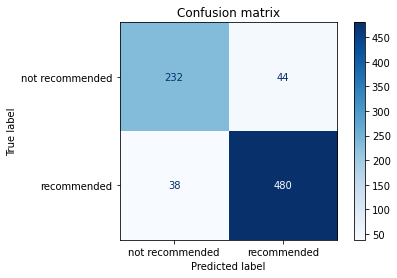

In [43]:
target_names = ['not recommended', 'recommended']

cm_plot = ConfusionMatrixDisplay.from_estimator(
        model,
        data_test,
        target_test,
        display_labels=target_names,
        cmap=plt.cm.Blues,
        )
cm_plot.ax_.set_title("Confusion matrix")

print(cm_plot.confusion_matrix)


In [31]:
# Manual check of correct predictions and FP and FN

targets = target_test.to_list()
predictions = list(target_predictions)
zipped = zip(targets, predictions)
df_comparison = pd.DataFrame(zipped, columns=["Targets", "Predictions"])
df_comparison["Difference"] = df_comparison.Targets - df_comparison.Predictions
df_comparison.Difference.value_counts()

 0    712
-1     44
 1     38
Name: Difference, dtype: int64

In [42]:
df_comparison.Targets.value_counts()

1    518
0    276
Name: Targets, dtype: int64